In [79]:
%matplotlib widget
# %matplotlib inline
%load_ext line_profiler
import numpy as np
import time
import seaborn as sns
import pandas as pd
from scipy import spatial, stats
from functools import reduce
from tqdm import tqdm
from collections import defaultdict
from numba import njit
import matplotlib.pyplot as plt
import nrrd
import pytest
import multiprocessing as mp
import raster_geometry as rg
import sys
import os
import cv2
sys.path.append("C:\\Users\\danie\\BoneSegmentation")

from oiffile import OifFile
from src.OifImageViewer import OifImageViewer

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [80]:
### Loading Confocal Image (.OIB)

path = "/home/dkermany/data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20181009_103052.oib"
# path = "D:\\Datasets\\Bone_Mets\\FV10__oibs\\FV10__20190620_111343.oib"
filename = os.path.splitext(os.path.basename(path))[0]

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)
    x_step, y_step, z_step = map(float, (viewer.md["x_step"], viewer.md["y_step"], viewer.md["z_step"]))
    if viewer.md["z_unit"] == "nm":
        z_step /= 1000.

Image shape: (3, 75, 2051, 8578)
Axes: CZYX
Dtype: uint16
Intervals: X (1.242um) Y (1.242um) Z (2660nm)



In [81]:
### Loading 3D Binary Mask (.SEG.NRRD)

# mask_path = "D:\\Datasets\\Bone_Mets\\masks\\FV10__20190620_111343.seg.nrrd"
# mask_path = "/home/dkermany/data/Bone_Project/masks/FV10__20190620_111343.seg.nrrd"
mask_path = f"/home/dkermany/data/Bone_Project/masks/{filename}.seg.nrrd"

# Load mask from NRRD
mask, header = nrrd.read(mask_path)
mask = mask.T
#mask = mask[:mask.shape[0]//3, :, :] # for FV10__20190620_111343.seg.nrrd

print(mask.shape)
print(mask.dtype)
print("Axes: ZYX")

(75, 2051, 8578)
uint8
Axes: ZYX


In [82]:
### Loading Tumor Cell Locations (.CSV)

# tumor_csv_path = "D:\\Datasets\\Bone_Mets\\tumor_locations.csv"
tumor_csv_path = "/home/dkermany/data/Bone_Project/tumor_locations_02_08_2023.csv"
# Load csv and drop rows with N/A's
tumor_csv = pd.read_csv(tumor_csv_path).dropna()
tumor_csv = tumor_csv[tumor_csv.Filename == filename].reset_index(drop=True)
# tumor_csv

In [83]:
def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Args:
    point1 (array-like): An array-like object representing the first point.
    point2 (array-like): An array-like object representing the second point.

    Returns:
    float: The Euclidean distance between the two points.
    """
    # Use NumPy's linalg.norm function to calculate the Euclidean distance
    return np.linalg.norm(point1-point2)

def micron_to_pixel(micron, scale_factor):
    pass

# Test distance function
print(euclidean_distance(np.array((10,10,10)),np.array((0,0,0))))

17.320508075688775


In [84]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

In [85]:
# @njit()
# def sphere_func(center, radius, shape):
#     arr = np.zeros(shape)
#     for i in range(shape[0]):
#         for j in range(shape[1]):
#             for k in range(shape[2]):
#                 x, y, z = i - center[0], j - center[1], k - center[2]
#                 dist = np.sqrt(x**2 + y**2 + z**2)
#                 if dist <= radius:
#                     arr[i,j,k] = 1
#     return arr

Draw sphere in a given volume
<a id='draw_sphere_in_volume'></a><br>
[Go to tumor function call](#tumor_ripley)

In [86]:
def draw_sphere_in_volume(volume: np.ndarray, radius: int, position: tuple) -> None:
    """
    Draw a sphere in a given 3D NumPy array at a specified position.

    Args:
    volume (numpy.ndarray): The 3D NumPy array in which the sphere will be drawn.
    radius (int): The radius of the sphere.
    position (tuple): A 3-tuple containing the z, y, x coordinates of the position in the array where the sphere will be drawn.

    Returns:
    None
    """
    
    # Create an empty 3D NumPy array with dimensions equal to twice the radius plus one
    size = 2 * (radius + 1)

    # Calculate the midpoint of the sphere unit array
    midpoint = [size / 2] * 3

    # Generate a unit sphere using the rg library's superellipsoid function
    sphere = rg.nd_superellipsoid(size, radius, position=midpoint,
                                  rel_sizes=False, rel_position=False).astype(np.int_)

    # Extract the z, y, x coordinates of the position where the sphere will be drawn
    z, y, x = map(round, position)

    # Calculate the delta change needed to center the sphere at the specified position
    d = (size//2)

    # Calculate the minimum and maximum indices for the z, y, x axes of the volume array
    # print(position, radius, x-d, x+d, max(x - d, 0), min(x + d, volume.shape[2]))
    zmin, zmax = max(z - d, 0), min(z + d, volume.shape[0])
    ymin, ymax = max(y - d, 0), min(y + d, volume.shape[1])
    xmin, xmax = max(x - d, 0), min(x + d, volume.shape[2])

    # Calculate the minimum indices for the z, y, x axes of the sphere array
    szmin = abs(z - d) if z - d < 0 else 0
    symin = abs(y - d) if y - d < 0 else 0
    sxmin = abs(x - d) if x - d < 0 else 0

    # Calculate the amount to cut off of the ends of the z, y, x axes of the sphere array
    szmax = abs(volume.shape[0] - (z + d)) if z + d > volume.shape[0] else 0
    symax = abs(volume.shape[1] - (y + d)) if y + d > volume.shape[1] else 0
    sxmax = abs(volume.shape[2] - (x + d)) if x + d > volume.shape[2] else 0
    # assert x+d < volume.shape[2]
    
    # Trim the sphere array to fit within the trimmed volume array
    sphere = sphere[szmin:sphere.shape[0]-szmax, symin:sphere.shape[1]-symax, sxmin:sphere.shape[2]-sxmax]
    # Place the sphere within the larger volume array at the specified position

    # print(z, y, x, d, "|", zmin,zmax,"|",ymin,ymax,"|",xmin,xmax, "|",sphere.shape, "|", sxmin, sxmax)
    volume[zmin:zmax, ymin:ymax, xmin:xmax] = sphere

In [87]:
# # Test speed
# %time rg.nd_superellipsoid(2*80+1, 80, position=[40,40,40], rel_sizes=False, rel_position=False).astype(np.int_)
# test_vol = np.zeros(mask.shape, dtype=np.uint8)
# %time i = cle.draw_sphere(test_vol, 320, 640, 20, 80, 80, 80, 1)
# plt.figure()
# cle.imshow(i)

In [88]:
# ### Test draw sphere function
# import pyclesperanto_prototype as cle

# test_vol = np.zeros(mask.shape, dtype=np.uint8)
# draw_sphere_in_volume(test_vol, 80, (20, 640, 320))
# print(test_vol.dtype, mask.dtype)

# plt.figure()
# cle.imshow(test_vol)
# plt.figure()
# cle.imshow(mask)
# plt.figure()
# cle.imshow(test_vol & mask)


<!-- Ripley's K Estimators

![RipleyK](/img/ripleyK.png)

![RipleyL](/img/ripleyL.png)

![RipleyH](/img/ripleyH.png) -->

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BK%7D%28r%29%3D%20%5Cfrac%7BV%7D%7BN%28N-1%29%7D%20%5Csum_i%5EN%20%5Csum_%7Bj%20%5Cneq%20i%7D%5EN%20%20%5Cfrac%7BI%28d_%7Bi%2Cj%7D%3Cr%29%7D%7B%5Comega_%7Bi%2Cj%7D%7D%20%20%20%20%20&bc=White&fc=Black&im=jpg&fs=18&ff=arev&edit=0)

![link](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BL%7D%28r%29%3D%20%20%20%5Csqrt%5B3%5D%7B%5Cfrac%7B3%20%20%5Cwidehat%7BK%7D%28r%29%7D%7B4%5Cpi%7D%7D&bc=White&fc=Black&im=jpg&fs=18&ff=arev&edit=0)

![link](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BH%7D%28r%29%3D%5Cwidehat%7BL%7D%28r%29-r&bc=White&fc=Black&im=jpg&fs=12&ff=arev&edit=0)

In [89]:
cache = mp.Manager().dict()

In [90]:
### Ripley Class 

class Ripley():

    def __init__(
        self,
        points: np.ndarray,
        radii: list,
        mask: np.ndarray,
        boundary_correction: bool = True
    ):
        self.points = points
        self.radii = radii
        self.mask = mask.astype(np.uint8)
        self.volume_shape = self.mask.shape
        self.boundary_correction = boundary_correction
        self._validate_inputs()

        self.tree = spatial.cKDTree(self.points)
        self.study_volume = reduce(lambda x, y: x * y, self.volume_shape)

    def run_ripley(self, processes=32):
        with mp.Manager() as m:
            self.results = {"K": m.list(), "L": m.list(), "H": m.list()}
            with mp.Pool(processes) as pool:
                # pool.map(self._calc_ripley, self.radii)
                list(tqdm(pool.imap(self._calc_ripley, self.radii), total=len(self.radii)))
            return list(self.results["K"]), list(self.results["L"]), list(self.results["H"])

    def _calc_ripley(self, radius):
        # For each radius, loop through each point and count points
        # within the radius
        print("???")
        nb_count = 0
        for z, y, x in self.points:
            if self.boundary_correction:
                weight = self.calculate_weight(radius, (z, y, x))
                # If weight is zero (i.e. target sphere not in mask), move on
                if weight == 0:
                    continue
            else:
                weight = 1.0

            # query_ball_point() includes the index of the current point as well
            # so 1 is subtracted from the count 
            nb_count += (len(self.tree.query_ball_point([z, y, x], radius)) - 1) / weight

            # global pbar
            # pbar.update()


         # calculating 3D Ripley's functions (K, L, H)
        N = self.points.shape[0]
        K = nb_count * self.study_volume / (N * (N - 1))
        L = ((3. / 4) * (K / np.pi)) ** (1. / 3)
        H = L - radius
        
        # Verify K/L values positive
        if K < 0 or L < 0:
            raise ValueError(f"K/L values should not be negative. nb_count: {nb_count}, volume: {self.volume_shape}, N: {N}")

        self.results["K"].append((radius, K))
        self.results["L"].append((radius, L))
        self.results["H"].append((radius, H))

    def calculate_weight(self, radius, center):
        """
        Calculate the proportion of a sphere within a study volume.

        Args:
        radius (int): The radius of the sphere.
        center (tuple): A 3-tuple containing the z, y, x coordinates of the center of the sphere.

        Returns:
        float: The proportion of the sphere within the study volume.
        """
        # Ensure that the radius is greater than zero
        assert radius > 0

        # Check if cached weight for this coordinate exists
        key = center + (radius,)
        if key in cache:
            return cache[key]
        
        # Draw the target sphere in a 3D NumPy array at the specified position
        target = np.zeros(self.volume_shape, dtype=np.uint8)
        draw_sphere_in_volume(target, radius, center)

        # Bitwise and operation between the sphere and mask to calculate intersection
        target = target & self.mask

        # Calculate the sum (volume) of the target and reference sphere arrays
        target = target.sum()

        # Reference is calculated instead of simulated for speed increase
        reference = (4 / 3) * np.pi * (radius ** 3)

        # Ensure that the reference sphere has a non-zero volume
        assert reference > 0

        # Return the proportion of the sphere within the study volume
        # Since target volume is estimated whereas reference volume is calculated,
        # there is a small but noticable margin of error when radius < 10, there
        # we set maxiumum value of 1.0
        weight = min(target / reference, 1.0)

        # Save weight to cache
        cache[key] = weight
        
        return weight

    def _validate_inputs(self):
        # Check if self.points is a list or numpy array
        if not isinstance(self.points, (list, np.ndarray)):
            e = f"Expected {np.ndarray}, received {type(self.points)}"
            raise ValueError(e)

        # Convert self.points to numpy array if it is a list
        if not isinstance(self.points, np.ndarray):
            self.points = np.array(self.points)

        # Check if self.points array has two dimensions
        if len(self.points.shape) != 2:
            e = f"Expected self.points array to have 2 dimensions, but got array with shape {self.points.shape}"
            raise ValueError(e)

        # Check if the self.points array second dimension length is 3 (x, y, z)
        if self.points.shape[1] != 3:
            e = f"Expected self.points array to have shape (None, 3), but got array with shape {self.points.shape}"
            raise ValueError(e)

        # Check if the self.points array has at least 3 points
        if self.points.shape[0] < 3:
            e = f"Expected self.points array to have at least 3 points"
            raise ValueError(e)

        # Check if radii is list-like or number-like
        if not isinstance(self.radii, (np.ndarray, list, int, float)):
            e = f"Expected {(np.ndarray, list, int, float)}, received {type(self.radii)}"
            raise ValueError(e)

        # if only one radius given as int, convert to list
        if not isinstance(self.radii, (np.ndarray, list)):
            self.radii = [self.radii]

In [91]:
### Multivariate Ripley Class

class CrossRipley(Ripley):


    def __init__(
        self,
        points_i: np.ndarray,
        points_j: np.ndarray,
        radii: list,
        mask: np.ndarray,
        boundary_correction: bool = False
    ):
        self.points_i = points_i
        self.points_j = points_j
        self.radii = radii
        self.mask = mask.astype(np.uint8)
        self.volume_shape = self.mask.shape
        self.boundary_correction = boundary_correction
        self._validate_inputs()

        self.i_tree = spatial.cKDTree(self.points_i)
        self.j_tree = spatial.cKDTree(self.points_j)
        self.study_volume = reduce(lambda x, y: x * y, self.volume_shape)


    def test_ripley(self):
        self.results = {"K": [], "L": [], "H": []}
        for r in tqdm(self.radii):
            self._calc_ripley(r)
        return list(self.results["K"]), list(self.results["L"]), list(self.results["H"])

    # TODO: Rewrite univariate _calc_ripley function for multivariate case
    def _calc_ripley(self, radius):
        """
        Calculate 3D multivariate Ripley's functions (K_ij, L_ij, H_ij) for a given radius and
        and apply weight coefficient.

        For each radius, loop through each point_i and count number of point_j within the radius.
        If boundary_correction is True, calculate the weight coefficient based on the volume of
        the search sphere within the study volume.

        Args:

            radius (float): the radius for which to calculate Ripley's functions.

        Raises:
            ValueError: if K/L values are negative.

        Returns:
            None. Results are stored in self.results.

        """
        # For each radius, loop through each point and count points
        # within the radius
        nb_count = 0
        for z, y, x in self.points_i:
            # print(f"{i}/{len(self.points_i)}", end="\r")
            if self.boundary_correction:
                weight = self.calculate_weight(radius, (z, y, x))
                # If weight is zero (i.e. target sphere not in mask), move on
                if weight == 0:
                    continue
            else:
                weight = 1.0

            # Since the i point is not included within the j_tree, we do not subtract 1
            # as done in the univariate implementation
            
            nb_count += (len(self.j_tree.query_ball_point([z, y, x], radius, workers=-1))) / weight

            # global pbar
            # pbar.update()

        # calculating 3D Ripley's functions (K_ij, L_ij, H_ij)
        N_i = self.points_i.shape[0]
        N_j = self.points_j.shape[0]
        K_ij = nb_count * self.study_volume / (N_i * N_j)
        L_ij = ((3. / 4) * (K_ij / np.pi)) ** (1. / 3)
        H_ij = L_ij - radius
        
        # Verify K/L values positive
        if K_ij < 0 or L_ij < 0:
            raise ValueError(f"K/L values should not be negative. nb_count: {nb_count}, volume: {self.volume_shape}, N_i: {N_i}, N_j: {N_j}")

        self.results["K"].append((radius, K_ij))
        self.results["L"].append((radius, L_ij))
        self.results["H"].append((radius, H_ij))

    def _validate_inputs(self):
        # Check if self.points_i is a list or numpy array
        if not isinstance(self.points_i, (list, np.ndarray)):
            e = f"Expected {np.ndarray}, received {type(self.points_i)}"
            raise ValueError(e)

        # Check if self.points_j is a list or numpy array
        if not isinstance(self.points_j, (list, np.ndarray)):
            e = f"Expected {np.ndarray}, received {type(self.points_j)}"
            raise ValueError(e)

        # Convert self.points_i to numpy array if it is a list
        if not isinstance(self.points_i, np.ndarray):
            self.points_i = np.array(self.points_i)
            
        # Convert self.points_j to numpy array if it is a list
        if not isinstance(self.points_j, np.ndarray):
            self.points_j = np.array(self.points_j)

        # Check if self.points_i array has two dimensions
        if len(self.points_i.shape) != 2:
            e = f"Expected self.points_i array to have 2 dimensions, but got array with shape {self.points_i.shape}"
            raise ValueError(e)

        # Check if self.points_j array has two dimensions
        if len(self.points_j.shape) != 2:
            e = f"Expected self.points_j array to have 2 dimensions, but got array with shape {self.points_j.shape}"
            raise ValueError(e)

        # Check if the self.points_i array second dimension length is 3 (x, y, z)
        if self.points_i.shape[1] != 3:
            e = f"Expected self.points_i array to have shape (None, 3), but got array with shape {self.points_i.shape}"
            raise ValueError(e)

        # Check if the self.points_j array second dimension length is 3 (x, y, z)
        if self.points_j.shape[1] != 3:
            e = f"Expected self.points_j array to have shape (None, 3), but got array with shape {self.points_j.shape}"
            raise ValueError(e)

        # Check if the self.points_i array has at least 3 points
        if self.points_i.shape[0] < 3:
            e = f"Expected self.points_i array to have at least 3 points"
            raise ValueError(e)

        # Check if the self.points_j array has at least 3 points
        if self.points_j.shape[0] < 3:
            e = f"Expected self.points_j array to have at least 3 points"
            raise ValueError(e)

        # Check if radii is list-like or number-like
        if not isinstance(self.radii, (np.ndarray, list, int, float)):
            e = f"Expected {(np.ndarray, list, int, float)}, received {type(self.radii)}"
            raise ValueError(e)

        # if only one radius given as int, convert to list
        if not isinstance(self.radii, (np.ndarray, list)):
            self.radii = [self.radii]

        # if points are not within volume, raise error
        for p in [self.points_i, self.points_j]:
            assert all(x < self.volume_shape[2] for x in p[:, 2])
            assert all(y < self.volume_shape[1] for y in p[:, 1])
            assert all(z < self.volume_shape[0] for z in p[:, 0])

In [92]:
### Test sphere drawing

# def draw_sphere(shape, radius, center) -> np.ndarray:
#     sphere = rg.nd_superellipsoid(shape, radius, position=center, rel_sizes=False, rel_position=False)
#     return sphere.astype(np.int_)

# container_shape = (100, 100, 100)
# radius = 7
# center = (2, 2, 2)

# # print(calculate_weight(container_shape, radius, center))
# test_sphere = draw_sphere(container_shape, radius, center)

# from mpl_toolkits.mplot3d import Axes3D
# z,x,y = test_sphere.nonzero()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# set_aspect_ratio_equal(ax)
# ax.axes.set_xlim3d(left=0, right=container_shape[1]) 
# ax.axes.set_ylim3d(bottom=0, top=container_shape[2]) 
# ax.axes.set_zlim3d(bottom=0, top=container_shape[0]) 
# ax.scatter(x, y, z, zdir='z', c= 'red')
# plt.show()

In [93]:
# def sample_clustered_points(points):
#     from random import randrange
#     """
#     Given a set of points, returns a second set of points that are spatially
#     related
#     """
#     new_points = [[z+randrange(0,11)-5, y+randrange(0,11)-5, x+randrange(0,11)-5] for z, y, x in points]
#     return np.array(new_points)

In [94]:
# ### Visualize Multivariate Points Within Sphere
# random_DTC = stats.uniform.rvs(loc=0, scale=100, size=(100,3))
# random_NG2 = sample_clustered_points(random_DTC)
# # random_NG2 = stats.uniform.rvs(loc=0, scale=100, size=(100,3))
# # random_NG2 = stats.skewnorm.rvs(a=4, loc=50, scale=25, size=(100,3))

# DTC_tree = spatial.cKDTree(random_DTC)
# NG2_tree = spatial.cKDTree(random_NG2)

# DTC_idx_in = DTC_tree.query_ball_point((50,50,50), 20)
# NG2_idx_in = NG2_tree.query_ball_point((50,50,50), 20)

In [95]:
# DTC_idx_out = np.ones(len(random_DTC), bool); DTC_idx_out[DTC_idx_in] = 0
# NG2_idx_out = np.ones(len(random_NG2), bool); NG2_idx_out[NG2_idx_in] = 0

# DTC_inside, DTC_outside = random_DTC[DTC_idx_in], random_DTC[DTC_idx_out]
# NG2_inside, NG2_outside = random_NG2[NG2_idx_in], random_NG2[NG2_idx_out]

# DTC_ix, DTC_ox = DTC_inside[:, 0], DTC_outside[:, 0]
# DTC_iy, DTC_oy = DTC_inside[:, 1], DTC_outside[:, 1]
# DTC_iz, DTC_oz = DTC_inside[:, 2], DTC_outside[:, 2]

# NG2_ix, NG2_ox = NG2_inside[:, 0], NG2_outside[:, 0]
# NG2_iy, NG2_oy = NG2_inside[:, 1], NG2_outside[:, 1]
# NG2_iz, NG2_oz = NG2_inside[:, 2], NG2_outside[:, 2]

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# set_aspect_ratio_equal(ax)
# ax.scatter(DTC_ix,DTC_iy,DTC_iz, color="g",marker="o", depthshade=0)
# ax.scatter(DTC_ox,DTC_oy,DTC_oz,color="y",marker="o", depthshade=1)
# ax.scatter(NG2_ix,NG2_iy,NG2_iz, color="r",marker="o", depthshade=0)
# ax.scatter(NG2_ox,NG2_oy,NG2_oz,color="m",marker="o", depthshade=1)

# scale = 20
# # draw sphere
# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# cx = scale*np.cos(u)*np.sin(v)+50
# cy = scale*np.sin(u)*np.sin(v)+50
# cz = scale*np.cos(v)+50
# ax.plot_wireframe(cx, cy, cz, color="gray", alpha=0.3)

In [96]:
# For this rectangular test case, volume_mask is just an array of ones
# volume_mask = np.ones((100, 100, 100))
# volume = volume_mask.sum()
# volume_shape = volume_mask.shape

In [97]:
# ### Run Multivariate (Cross) Ripley on Random Points data
# crossripley_data = []
# crossripley_data_w = []

# radii = np.arange(2, 67) 
# crossripley = CrossRipley(random_DTC, random_NG2, radii, volume_mask, boundary_correction=False)
# crossripley_w = CrossRipley(random_DTC, random_NG2, radii, volume_mask, boundary_correction=True)

# K, L, H = map(sorted, crossripley.run_ripley(1))
# K_w, L_w, H_w = map(sorted, crossripley_w.run_ripley(16))

# # Organize into list of [Radius, K, L, H, Type, Line] 
# crossripley_data += [(k[0], k[1], l[1], h[1], "CSR") for k, l, h in zip(K, L, H)]
# crossripley_data_w += [(k[0], k[1], l[1], h[1], "CSR") for k, l, h in zip(K_w, L_w, H_w)]

# rstats = pd.DataFrame(crossripley_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])
# rstats_w = pd.DataFrame(crossripley_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])

In [98]:
# plt.rcParams['figure.figsize'] = [16, 9]
# f, axes = plt.subplots(2, 3)
# tumor_data_w = []

# # Max ripley search sphere size. Typically 1/3 or 1/2 of smallest dimension
# # max_search_radius = min(mask.shape) // 3
# ripley = Ripley(tumor_points, tumor_radii, mask, boundary_correction=False)
# ripley_w = Ripley(tumor_points, tumor_radii, mask, boundary_correction=True)

# # Sort by radii
# K, L, H = map(sorted, ripley.run_ripley(2))
# K_w, L_w, H_w = map(sorted, ripley_w.run_ripley(63))

# # Organize into list of [Radius, K, L, H, Type, Line] 
# tumor_data += [(k[0], k[1], l[1], h[1], "Tumor") for k, l, h in zip(K, L, H)]
# tumor_data_w += [(k[0], k[1], l[1], h[1], "Tumor") for k, l, h in zip(K_w, L_w, H_w)]
    
# tumor_rstats = pd.DataFrame(tumor_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])
# tumor_rstats_w 
# axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2])
# axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# ## Bottom Row
# # K
# sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=1)
# # L
# sns.lineplot(data=rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=1)
# axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=1)
# axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# plt.show()

In [99]:
### Visualize Univariate Points Within Sphere

# test_random_points = stats.uniform.rvs(0, 100, (100,3))
# test_tree = spatial.cKDTree(test_random_points)
# idx_in = test_tree.query_ball_point((50,50,50),20)

# idx_out = np.ones(len(test_random_points), bool)
# idx_out[idx_in] = 0

# pts_inside_radius = test_random_points[idx_in]
# pts_outside_radius = test_random_points[idx_out]

# print(len(test_random_points), len(pts_inside_radius), len(pts_outside_radius))

# ix, ox = pts_inside_radius[:, 0], pts_outside_radius[:, 0]
# iy, oy = pts_inside_radius[:, 1], pts_outside_radius[:, 1]
# iz, oz = pts_inside_radius[:, 2], pts_outside_radius[:, 2]

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# set_aspect_ratio_equal(ax)
# ax.scatter(ix,iy,iz, color="b",marker="o", depthshade=0)
# ax.scatter(ox,oy,oz,color="r",marker="o", depthshade=1)


# scale = 20
# # draw sphere
# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# cx = scale*np.cos(u)*np.sin(v)+50
# cy = scale*np.sin(u)*np.sin(v)+50
# cz = scale*np.cos(v)+50
# ax.plot_wireframe(cx, cy, cz, color="gray", alpha=0.3)

### Complete Spatial Randomness (CSR) Representations

In [100]:
# CSR_data = []
# CSR_data_w = []
# # Starting at 2 because radius of 1 causes errors at the boundaries
# # where sometimes the entire circle falls outside of study area
# # resulting in a weight of 0.0
# radii=np.arange(2, 67) 
# n_samples = 5
# for n in range(n_samples):
#     print(f"{n}/{n_samples}")
#     CSR_points = stats.uniform.rvs(0, 100, (100,3))
#     # pbar = tqdm(total=len(CSR_points))
#     ripley = Ripley(CSR_points, radii, volume_mask, boundary_correction=False)
#     ripley_w = Ripley(CSR_points, radii, volume_mask, boundary_correction=True)

#     # Sort by radii
#     K, L, H = map(sorted, ripley.run_ripley(1))
#     print("done")
#     K_w, L_w, H_w = map(sorted, ripley_w.run_ripley(8))

#     # Organize into list of [Radius, K, L, H, Type, Line] 
#     CSR_data += [(k[0], k[1], l[1], h[1], "CSR", n) for k, l, h in zip(K, L, H)]
#     CSR_data_w += [(k[0], k[1], l[1], h[1], "CSR", n) for k, l, h in zip(K_w, L_w, H_w)]
    
# rstats = pd.DataFrame(CSR_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
# rstats_w = pd.DataFrame(CSR_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
# rstats_w

In [101]:
# plt.rcParams['figure.figsize'] = [16, 9]
# f, axes = plt.subplots(2, 3)

# ## Top Row
# # K
# sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0], hue="Line")
# # L
# sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1], hue="Line")
# axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2], hue="Line")
# axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# ## Bottom Row
# # K
# sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# # L
# sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
# axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("ci", 95))
# axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# plt.show()



In [102]:
# f, axes = plt.subplots(2, 3,)

# ## Top Row
# # K
# sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", ax=axes[0, 0], hue="Line")
# # L
# sns.lineplot(data=rstats_w, x="Radius (r)", y="L(r)", ax=axes[0, 1], hue="Line")
# axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=rstats_w, x="Radius (r)", y="H(r)", ax=axes[0, 2], hue="Line")
# axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# ## Bottom Row
# # K
# sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# # L
# sns.lineplot(data=rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
# axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
# axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# plt.show()

In [103]:
# import ipytest
# ipytest.autoconfig(raise_on_error=True)
# %%ipytest -qq

# # Tests

# def test_valid_input():
#     valid_points = [
#         np.array([[38.4002419, 38.62931512, 41.6131775], [38, 38, 41], [1, 6, 8]]),
#         np.array([[38, 38, 41], [1, 2, 3], [20, 20, 20]]),
#         [[38.4002419, 38.62931512, 41.6131775], [3.4002419, 8.62931512, 1.6131775], [8.4002419, 3.62931512, 4.6131775]],
#         [[38, 38, 41], [1, 2, 3], [4, 5, 6]],
#     ]
#     for p in valid_points:
#         ripley(p, radii=1, volume_shape=(100,100,100))

# def test_invalid_input():
#     invalid_points = [
#         np.array([[38.4002419, 38.62931512, 41.6131775]]),
#         np.array([[38, 38, 41], [1, 2, 3]]),
#         [[38.4002419, 38.62931512, 41.6131775]],
#         [[38, 38, 41], [1, 2, 3]],
#         "38.4002419, 38.62931512, 41.6131775",
#         np.array([38.4002419, 38.62931512, 41.6131775]),
#         np.array([[[38.4002419, 38.62931512, 41.6131775]]]),
#         np.array([[38.4002419, 38.62931512]]),
#         5,
#         7.8,
#         [6],
#     ]
#     for p in invalid_points:
#         with pytest.raises(ValueError):
#             ripley(p, radii=1, volume_shape=(100,100,100))


In [104]:
tumor_dict = tumor_csv.to_dict("index")
# tumor_dict

In [105]:
tumor_points = []
for idx, tumor_info in tumor_dict.items():
    x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
    x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
    tumor_points.append([z, y, x])

tumor_points = np.array(tumor_points, dtype=np.float64)
n_tumor_points = tumor_points.shape[0]

In [106]:
stats.uniform.rvs(0, 100)

92.10418438616504

In [107]:

# CSR_tumor_data = []
# CSR_tumor_data_w = []

# n_samples = 20
# tumor_radii = np.arange(2, 400)
# for n in range(n_samples):

#     ## Generate random (CSR) points within the mask
#     CSR_tumor_points = np.empty((n_tumor_points, 3), dtype=np.uint16)
#     for i in range(n_tumor_points):
#         # if generated point outside of mask, repeat, else break
#         while(True):
#             z, y, x = map(int, [stats.uniform.rvs(0, mask.shape[j]) for j in range(3)])
#             if mask[z, y, x] == 1:
#                 CSR_tumor_points[i] = np.array([z, y, x])
#                 break
            
#     ripley = Ripley(CSR_tumor_points, tumor_radii, mask, boundary_correction=False)
#     ripley_w = Ripley(CSR_tumor_points, tumor_radii, mask, boundary_correction=True)

#     # Sort by radii
#     K, L, H = map(sorted, ripley.run_ripley(1))
#     K_w, L_w, H_w = map(sorted, ripley_w.run_ripley(63))

#     # Organize into list of [Radius, K, L, H, Type, Line] 
#     CSR_tumor_data += [(k[0], k[1], l[1], h[1], "Tumor_CSR", n) for k, l, h in zip(K, L, H)]
#     CSR_tumor_data_w += [(k[0], k[1], l[1], h[1], "Tumor_CSR", n) for k, l, h in zip(K_w, L_w, H_w)]
    
# CSR_tumor_rstats = pd.DataFrame(CSR_tumor_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
# CSR_tumor_rstats_w = pd.DataFrame(CSR_tumor_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])

In [108]:
# CSR_tumor_rstats.to_csv("/home/dkermany/test.csv")

Tumor Ripley Call
<a id="tumor_ripley"></a><br>
[Draw Sphere Function](#draw_sphere_in_volume)


In [109]:
# tumor_data = []
# tumor_data_w = []

# # Max ripley search sphere size. Typically 1/3 or 1/2 of smallest dimension
# # max_search_radius = min(mask.shape) // 3
# ripley = Ripley(tumor_points, tumor_radii, mask, boundary_correction=False)
# ripley_w = Ripley(tumor_points, tumor_radii, mask, boundary_correction=True)

# # Sort by radii
# K, L, H = map(sorted, ripley.run_ripley(2))
# K_w, L_w, H_w = map(sorted, ripley_w.run_ripley(63))

# # Organize into list of [Radius, K, L, H, Type, Line] 
# tumor_data += [(k[0], k[1], l[1], h[1], "Tumor") for k, l, h in zip(K, L, H)]
# tumor_data_w += [(k[0], k[1], l[1], h[1], "Tumor") for k, l, h in zip(K_w, L_w, H_w)]
    
# tumor_rstats = pd.DataFrame(tumor_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])
# tumor_rstats_w = pd.DataFrame(tumor_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])



In [110]:
# f, axes = plt.subplots(2, 3,)

# ## Top Row
# # K
# sns.lineplot(data=tumor_rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0])
# sns.lineplot(data=CSR_tumor_rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0], alpha=0, errorbar=("pi", 95))
# # L
# sns.lineplot(data=tumor_rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1])
# sns.lineplot(data=CSR_tumor_rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1], alpha=0, errorbar=("pi", 95))
# axes[0, 1].plot([0, 400], [0, 400], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=tumor_rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2])
# sns.lineplot(data=CSR_tumor_rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2], alpha=0, errorbar=("pi", 95))
# axes[0, 2].plot([0, 400], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# ## Bottom Row - Boundary Corrected
# # K
# sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0])
# sns.lineplot(data=CSR_tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# # L
# sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1])
# sns.lineplot(data=CSR_tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
# axes[1, 1].plot([0, 400], [0, 400], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2])
# sns.lineplot(data=CSR_tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
# axes[1, 2].plot([0, 400], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# plt.show()

In [111]:
# f, axes = plt.subplots(2, 3,)

# ## Top Row
# # K
# sns.lineplot(data=CSR_tumor_rstats, x="Radius (r)", y="K(r)", ax=axes[-1, 0], alpha=0, errorbar=("pi", 95))
# # L
# sns.lineplot(data=CSR_tumor_rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1], alpha=0, errorbar=("pi", 95))
# axes[0, 1].plot([0, 400], [0, 400], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=CSR_tumor_rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2], alpha=0, errorbar=("pi", 95))
# axes[0, 2].plot([0, 400], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# ## Bottom Row
# # K
# sns.lineplot(data=CSR_tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# # L
# sns.lineplot(data=CSR_tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
# axes[1, 1].plot([0, 400], [0, 400], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=CSR_tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
# axes[1, 2].plot([0, 400], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

# plt.show()



In [112]:
ng2_points_path = f"/home/dkermany/data/Bone_Project/NG2_Centroids/{filename}_NG2_centroids.npy"
ng2_points = np.flip(np.load(ng2_points_path).T, axis=1) # put points into Z,Y,X format (N, 3)
cross_tumor_radii = np.arange(2, 300)

In [113]:
print(f"Tumor points: {tumor_points.shape}")
print(f"NG2 points: {ng2_points.shape}")

Tumor points: (27, 3)
NG2 points: (1193, 3)


In [114]:

# cross_tumor_data = []
cross_tumor_data_w = []

# Max ripley search sphere size. Typically 1/3 or 1/2 of smallest dimension
# max_search_radius = min(mask.shape) // 3
# ripley = CrossRipley(tumor_points, ng2_points, cross_tumor_radii, mask, boundary_correction=False)
ripley_w = CrossRipley(tumor_points, ng2_points, cross_tumor_radii, mask, boundary_correction=True)

# Sort by radii
# K, L, H = map(sorted, ripley.run_ripley(1))
K_w, L_w, H_w = map(sorted, ripley_w.run_ripley(63))

# # Organize into list of [Radius, K, L, H, Type] 
# cross_tumor_data += [(k[0], k[1], l[1], h[1], "Tumor") for k, l, h in zip(K, L, H)]
cross_tumor_data_w += [(k[0], k[1], l[1], h[1], "Tumor") for k, l, h in zip(K_w, L_w, H_w)]
    
# cross_tumor_rstats = pd.DataFrame(cross_tumor_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])
cross_tumor_rstats_w = pd.DataFrame(cross_tumor_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])

# cross_tumor_rstats.to_csv(f"/home/dkermany/ripley_results/{filename}_rstats.csv")
cross_tumor_rstats_w.to_csv(f"/home/dkermany/ripley_results/{filename}_rstats_w.csv")


100%|█████████████████████████████████████████| 298/298 [13:35<00:00,  2.74s/it]


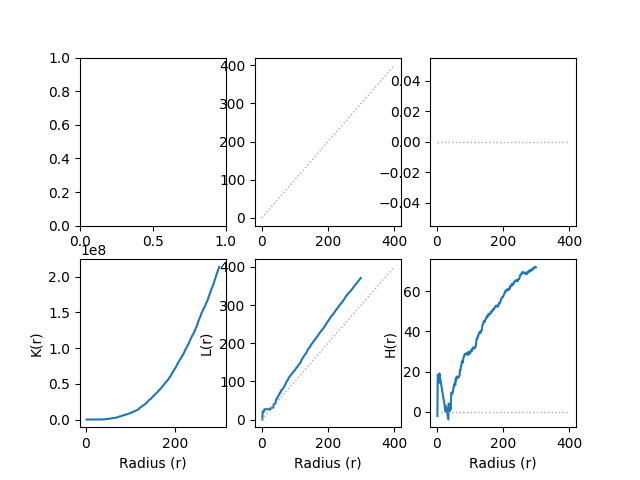

In [115]:

f, axes = plt.subplots(2, 3,)

## Top Row
# K
# sns.lineplot(data=cross_tumor_rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0])
# L
# sns.lineplot(data=cross_tumor_rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1])
axes[0, 1].plot([0, 400], [0, 400], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
# sns.lineplot(data=cross_tumor_rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2])
axes[0, 2].plot([0, 400], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row
# K
sns.lineplot(data=cross_tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0])
# L
sns.lineplot(data=cross_tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1])
axes[1, 1].plot([0, 400], [0, 400], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=cross_tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2])
axes[1, 2].plot([0, 400], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()


In [116]:
# tumor_data = []
# tumor_data_w = []

# # Max ripley search sphere size. Typically 1/3 or 1/2 of smallest dimension
# # max_search_radius = min(mask.shape) // 3
# ripley = Ripley(tumor_points, tumor_radii, mask, boundary_correction=False)
# ripley_w = Ripley(tumor_points, tumor_radii, mask, boundary_correction=True)

# # Sort by radii
# K, L, H = map(sorted, ripley.run_ripley(2))
# K_w, L_w, H_w = map(sorted, ripley_w.run_ripley(63))

# # Organize into list of [Radius, K, L, H, Type, Line] 
# tumor_data += [(k[0], k[1], l[1], h[1], "Tumor") for k, l, h in zip(K, L, H)]
# tumor_data_w += [(k[0], k[1], l[1], h[1], "Tumor") for k, l, h in zip(K_w, L_w, H_w)]
    
# tumor_rstats = pd.DataFrame(tumor_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])
# tumor_rstats_w = pd.DataFrame(tumor_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])

In [117]:
def get_shuffled_labels(points1, points2):
    combined_arr = np.concatenate((points1, points2), axis=0)
    np.random.shuffle(combined_arr) # inplace shuffle
    return np.split(combined_arr, [points1.shape[0]])

In [118]:
# random_cross_tumor_data = []
random_cross_tumor_data_w = []

n_samples = 20
tumor_radii = np.arange(2, 100)
print(f"Source image: {filename}")
for n in range(n_samples):
    print(f"\nRunning Monte-Carlo Simulation {n}/{n_samples}\n")
    random_tumor_points, random_ng2_points = get_shuffled_labels(tumor_points, ng2_points)

    # ripley = CrossRipley(random_tumor_points, random_ng2_points, cross_tumor_radii, mask, boundary_correction=False)
    ripley_w = CrossRipley(random_tumor_points, random_ng2_points, cross_tumor_radii, mask, boundary_correction=True)

    # Sort by radii
    # K, L, H = map(sorted, ripley.run_ripley(1))
    K_w, L_w, H_w = map(sorted, ripley_w.run_ripley(63))

    # # Organize into list of [Radius, K, L, H, Type] 
    # random_cross_tumor_data += [(k[0], k[1], l[1], h[1], "Tumor", n) for k, l, h in zip(K, L, H)]
    random_cross_tumor_data_w += [(k[0], k[1], l[1], h[1], "Tumor", n) for k, l, h in zip(K_w, L_w, H_w)]

# random_cross_tumor_rstats = pd.DataFrame(random_cross_tumor_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
random_cross_tumor_rstats_w = pd.DataFrame(random_cross_tumor_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])

# random_cross_tumor_rstats.to_csv(f"/home/dkermany/ripley_results/{filename}_random_rstats.csv")
random_cross_tumor_rstats_w.to_csv(f"/home/dkermany/ripley_results/{filename}_random_rstats_w.csv")

Source image: FV10__20181009_103052

Running Monte-Carlo Simulation 0/20



100%|█████████████████████████████████████████| 298/298 [13:40<00:00,  2.75s/it]



Running Monte-Carlo Simulation 1/20



100%|█████████████████████████████████████████| 298/298 [13:36<00:00,  2.74s/it]



Running Monte-Carlo Simulation 2/20



100%|█████████████████████████████████████████| 298/298 [13:43<00:00,  2.76s/it]



Running Monte-Carlo Simulation 3/20



100%|█████████████████████████████████████████| 298/298 [13:01<00:00,  2.62s/it]



Running Monte-Carlo Simulation 4/20



100%|█████████████████████████████████████████| 298/298 [13:21<00:00,  2.69s/it]



Running Monte-Carlo Simulation 5/20



100%|█████████████████████████████████████████| 298/298 [13:39<00:00,  2.75s/it]



Running Monte-Carlo Simulation 6/20



100%|█████████████████████████████████████████| 298/298 [12:33<00:00,  2.53s/it]



Running Monte-Carlo Simulation 7/20



100%|█████████████████████████████████████████| 298/298 [13:15<00:00,  2.67s/it]



Running Monte-Carlo Simulation 8/20



100%|█████████████████████████████████████████| 298/298 [12:47<00:00,  2.57s/it]



Running Monte-Carlo Simulation 9/20



100%|█████████████████████████████████████████| 298/298 [12:46<00:00,  2.57s/it]



Running Monte-Carlo Simulation 10/20



100%|█████████████████████████████████████████| 298/298 [12:34<00:00,  2.53s/it]



Running Monte-Carlo Simulation 11/20



100%|█████████████████████████████████████████| 298/298 [12:01<00:00,  2.42s/it]



Running Monte-Carlo Simulation 12/20



100%|█████████████████████████████████████████| 298/298 [12:06<00:00,  2.44s/it]



Running Monte-Carlo Simulation 13/20



100%|█████████████████████████████████████████| 298/298 [12:02<00:00,  2.42s/it]



Running Monte-Carlo Simulation 14/20



100%|█████████████████████████████████████████| 298/298 [12:05<00:00,  2.44s/it]



Running Monte-Carlo Simulation 15/20



100%|█████████████████████████████████████████| 298/298 [11:33<00:00,  2.33s/it]



Running Monte-Carlo Simulation 16/20



100%|█████████████████████████████████████████| 298/298 [12:16<00:00,  2.47s/it]



Running Monte-Carlo Simulation 17/20



100%|█████████████████████████████████████████| 298/298 [10:48<00:00,  2.18s/it]



Running Monte-Carlo Simulation 18/20



100%|█████████████████████████████████████████| 298/298 [11:24<00:00,  2.30s/it]



Running Monte-Carlo Simulation 19/20



100%|█████████████████████████████████████████| 298/298 [11:08<00:00,  2.24s/it]


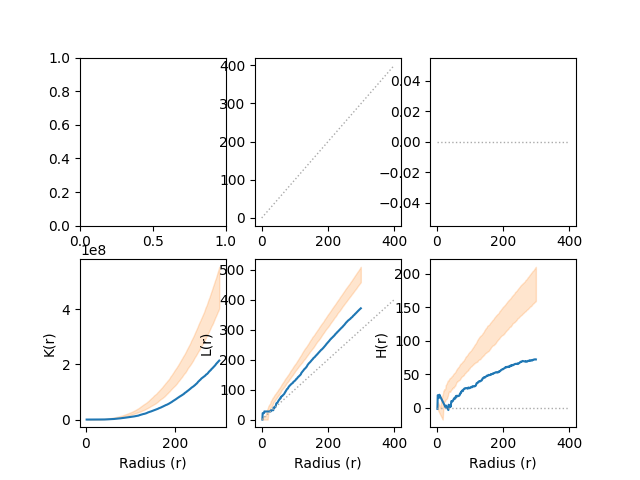

In [119]:
f, axes = plt.subplots(2, 3,)

## Top Row
# K
# sns.lineplot(data=cross_tumor_rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0])
# sns.lineplot(data=random_cross_tumor_rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0], alpha=0, errorbar=("pi", 95))
# L
# sns.lineplot(data=cross_tumor_rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1])
# sns.lineplot(data=random_cross_tumor_rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1], alpha=0, errorbar=("pi", 95))
axes[0, 1].plot([0, 400], [0, 400], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
# sns.lineplot(data=cross_tumor_rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2])
# sns.lineplot(data=random_cross_tumor_rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2], alpha=0, errorbar=("pi", 95))
axes[0, 2].plot([0, 400], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row - Boundary Corrected
# K
sns.lineplot(data=cross_tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0])
sns.lineplot(data=random_cross_tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# L
sns.lineplot(data=cross_tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1])
sns.lineplot(data=random_cross_tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
axes[1, 1].plot([0, 400], [0, 400], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=cross_tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2])
sns.lineplot(data=random_cross_tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
axes[1, 2].plot([0, 400], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()